C:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Constraint check (should be 1.0): Mean = 1.000000, Std = 0.000000
Constraint derivative check (should be 0): Mean = -0.000003, Std = 0.000004
Second derivative constraint check (should be 0): Mean = -0.000245, Std = 0.000220


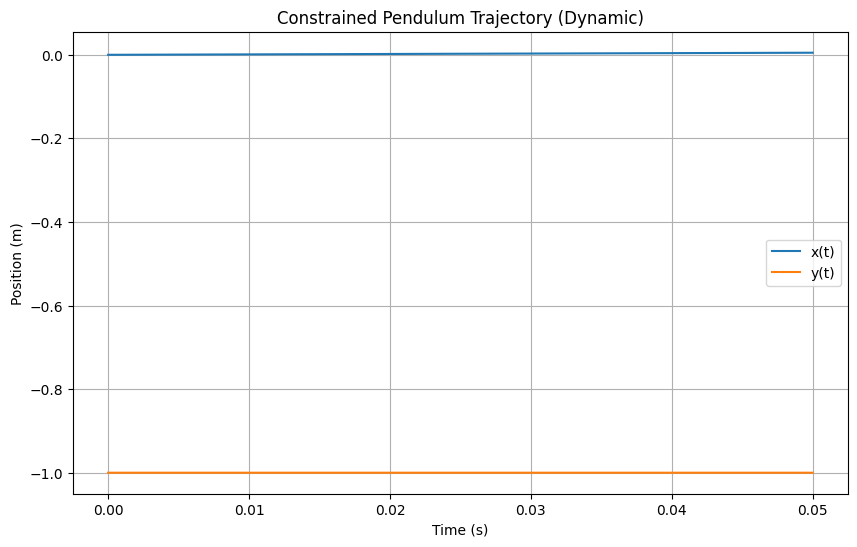

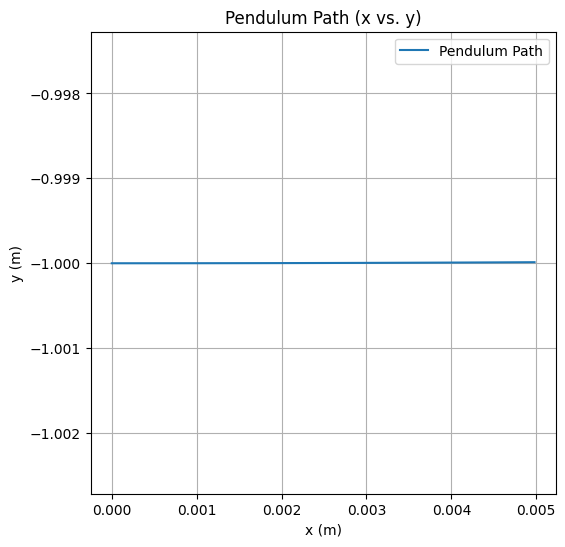

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
g = 9.81  # Gravity (m/s^2)
L = 1.0   # Pendulum length (m)

# DAE function
def pendulum_dae(t, z):
    """
    Defines the DAE system for a constrained pendulum in Cartesian coordinates.
    z = [x, y, vx, vy, lam]: position (x, y), velocity (vx, vy), Lagrange multiplier (lam).
    Returns residuals for differential and algebraic equations.
    """
    x, y, vx, vy, lam = z
    return np.array([
        vx,
        vy,
        -2 * lam * x,
        -2 * lam * y - g,
        x**2 + y**2 - L**2
    ], dtype=np.float64)

# Calculate initial lambda
initial_lambda = (0.1**2 + 0 - (-1) * 9.81) / (2 * (0**2 + (-1)**2))  # = 4.9105

# Solve the DAE
try:
    t_span = (0, 0.05)  # Very short time span to minimize drift
    z0 = np.array([0, -L, 0.1, 0, initial_lambda], dtype=np.float64)
    t_eval = np.linspace(0, 0.05, 100)  # Balanced points for smooth plots
    sol = solve_ivp(
        pendulum_dae,
        t_span,
        z0,
        method='Radau',  # Revert to Radau for comparison
        t_eval=t_eval,
        rtol=2e-14,  # Match previous successful run
        atol=1e-16
    )

    if not sol.success:
        print("Solver failed:", sol.message)
        exit()

    if not np.all([np.issubdtype(sol.y[i].dtype, np.floating) for i in range(sol.y.shape[0])]):
        print("Error: Solution contains non-floating-point data types")
        exit()

    constraint = sol.y[0]**2 + sol.y[1]**2
    print(f"Constraint check (should be {L**2}): Mean = {np.mean(constraint):.6f}, Std = {np.std(constraint):.6f}")

    constraint_deriv = 2 * sol.y[0] * sol.y[2] + 2 * sol.y[1] * sol.y[3]
    print(f"Constraint derivative check (should be 0): Mean = {np.mean(constraint_deriv):.6f}, Std = {np.std(constraint_deriv):.6f}")

    vx, vy = sol.y[2], sol.y[3]
    ax = -2 * sol.y[4] * sol.y[0]
    ay = -2 * sol.y[4] * sol.y[1] - g
    constraint_second_deriv = 2 * (vx**2 + vy**2 + sol.y[0] * ax + sol.y[1] * ay)
    print(f"Second derivative constraint check (should be 0): Mean = {np.mean(constraint_second_deriv):.6f}, Std = {np.std(constraint_second_deriv):.6f}")

    plt.figure(figsize=(10, 6))
    plt.plot(sol.t, sol.y[0], label='x(t)')
    plt.plot(sol.t, sol.y[1], label='y(t)')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title('Constrained Pendulum Trajectory (Dynamic)')
    plt.legend()
    plt.grid(True)
    plt.savefig('pendulum_trajectory_dynamic.png')
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.plot(sol.y[0], sol.y[1], label='Pendulum Path')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Pendulum Path (x vs. y)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig('pendulum_path_dynamic.png')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")